In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.3


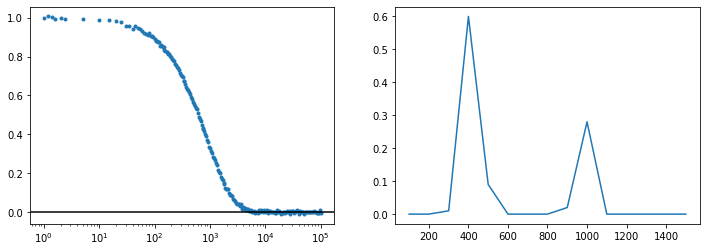

In [2]:
#### 只是为了得到实际的tau
from MultiAngleDls import multiAngleDls
filelist = ['test_data/PS_300nm_90degree.dat']
data = multiAngleDls(filelist, d_min=1, d_max=300, d_num=50)
####

tau = data.dlsDataList[0].tau * 1e-6
tau = tau.reshape((tau.size, 1))
gamma = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1300, 1500])
gamma = gamma.reshape((1, gamma.size))
G_real = np.array([0, 0, 0.01, 0.6, 0.09, 0, 0, 0, 0.02, 0.28, 0, 0, 0])  # G(gamma) is gamma distribution, real value
G_real = G_real.reshape((G_real.size, 1))

sigma = np.random.randn(tau.size, 1) * 0.005
g1square_exp = np.dot( np.exp(-np.dot(tau, gamma)), G_real)**2 + sigma

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(tau*1e6, g1square_exp, '.')
ax1.axhline(y=0, color='black')
ax1.set_xscale('log')
ax2 = fig.add_subplot(122)
ax2.plot(gamma.reshape(gamma.size), G_real.reshape(G_real.size), label='real')

In [3]:
model = pm.Model()

M = tau.size
n = G_real.size

######## 构建 prior ########
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

# second derivative operator matrix
# for prior use
L2 = np.zeros((n, n))
for j in range(L2.shape[0]-2):
    L2[j, j], L2[j, j+1], L2[j, j+2] = 1, -2, 1

# 这里试着建立一个指数分布
testG = np.ones_like(G_real) / n
testG = testG.reshape((testG.size, 1))
class prior(BoundedContinuous):
    def __init__(self, lower=np.zeros((n, 1)), L=L2, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.L = L = tt.as_tensor_variable(L)
        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is G
        lower = self.lower
        L = self.L
        return bound( -1 * tt.sum( tt.dot(L, value)**2 ), value >= lower )
#############################

###### 构建 likelihood ####### 
from pymc3.distributions import Continuous

testg1square = np.exp(-1*100*tau)**2
class likelihood(Continuous):

    def __init__(self, g1square_theo=testg1square, M=200, *args, **kwargs):
        self.g1square_theo = g1square_theo = tt.as_tensor_variable(g1square_theo)
        self.M = M = tt.as_tensor_variable(M)

        super().__init__(*args, **kwargs)

    def logp(self, value):
        # value here is g1square
        g1square_theo = self.g1square_theo
        M = self.M
        return -M/2 * tt.log( tt.sum( (value - g1square_theo)**2 ) )
#############################

with model:
    G = prior('G', lower=np.zeros_like(G_real), L=L2, shape=(n, 1), testval=testG)

    g1square_theo = tt.dot( tt.exp(-tt.dot(tau, gamma)), G)**2

    like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=g1square_exp)


In [5]:
with model:
    #step = pm.Metropolis()
    #step = pm.Slice()
    step = pm.NUTS()
    trace_slice = pm.sample(2000, step=step, cores=10, chains=10, tune=10000, discard_tuned_samples=True)

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [G]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    #step = pm.Metropolis()
    #step = pm.Slice()
    step = pm.NUTS()
    trace_nuts = pm.sample(1000, step=step, cores=10, chains=10, tune=5000, discard_tuned_samples=True)

In [ ]:
G_result_slice = np.sum(trace_slice['G'], axis=0) / (trace_slice['G'].shape[0]+1)
G_result_nuts = np.sum(trace_nuts['G'], axis=0) / (trace_nuts['G'].shape[0]+1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gamma.reshape(gamma.size), G_real.reshape(G_real.size), label='real')
ax.plot(gamma.reshape(gamma.size), G_result_slice.reshape(G_result_slice.size), label='Slice')
ax.plot(gamma.reshape(gamma.size), G_result_nuts.reshape(G_result_nuts.size), label='NUTS')
ax.legend()
plt.show()

In [ ]:
#az.summary(trace)